#<center>**Fine-Tune Llama 2**

#**Analyzing Pakistan's Prime Ministers: Fine-tuning Llama2 for Historical Insights**


#**Step 1: Install All the Required Packages**

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00


#**Step 2: Import All the Required Libraries**

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    AutoModelForSequenceClassification
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
import pandas as pd

#**In case of Llama 2, the following prompt template is used for the chat models**

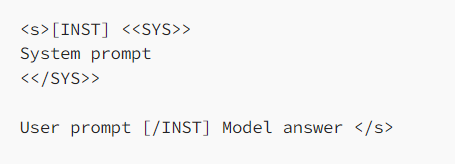

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "meta-llama/Llama-2-7b-chat-hf"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune-prime-minister-pakistan"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Prime Ministers Dataset and start the fine-tuning process**

In [ ]:
#  dataset
data = {
    'text': [
        "<s>[INST] Who was the prime minister from 15-08-1947 to 16-10-1951? [/INST] Liaqat Ali Khan was the prime minister from 15-08-1947 to 16-10-1951. </s>",
        "<s>[INST] Who was the prime minister from 17-10-1951 to 17-04-1953? [/INST] Khawaja Nazimuddin was the prime minister from 17-10-1951 to 17-04-1953. </s>",
        "<s>[INST] Who was the prime minister from 17-04-1953 to 11-08-1955? [/INST] Mohammad Ali Bogra was the prime minister from 17-04-1953 to 11-08-1955. </s>",
        "<s>[INST] Who was the prime minister from 11-08-1955 to 12-09-1956? [/INST] Ch. Mohammed Ali was the prime minister from 11-08-1955 to 12-09-1956. </s>",
        "<s>[INST] Who was the prime minister from 12-09-1956 to 18-10-1957? [/INST] Hussain Shaheed Suharwardi was the prime minister from 12-09-1956 to 18-10-1957. </s>",
        "<s>[INST] Who was the prime minister from 18-10-1957 to 16-12-1957? [/INST] Ibrahim Ismail Chaundrigar was the prime minister from 18-10-1957 to 16-12-1957. </s>",
        "<s>[INST] Who was the prime minister from 16-12-1957 to 07-10-1958? [/INST] Malik Feroz Khan Noon was the prime minister from 16-12-1957 to 07-10-1958. </s>",
        "<s>[INST] Who was the prime minister from 07-12-1971 to 20-12-1971? [/INST] Noor-ul-Amin was the prime minister from 07-12-1971 to 20-12-1971. </s>",
        "<s>[INST] Who was the prime minister from 14-08-1973 to 05-07-1977? [/INST] Zulfiqar Ali Bhutto was the prime minister from 14-08-1973 to 05-07-1977. </s>",
        "<s>[INST] Who was the prime minister from 23-03-1985 to 29-05-1988? [/INST] Muhammad Khan Junejo was the prime minister from 23-03-1985 to 29-05-1988. </s>",
        "<s>[INST] Who was the prime minister from 02-12-1988 to 06-08-1990? [/INST] Benazir Bhutto was the prime minister from 02-12-1988 to 06-08-1990. </s>",
        "<s>[INST] Who was the prime minister from 06-08-1990 to 06-11-1990? [/INST] Ghulam Mustafa Khan Jatoi was the prime minister from 06-08-1990 to 06-11-1990. </s>",
        "<s>[INST] Who was the prime minister from 06-11-1990 to 18-04-1993? [/INST] Mian Mohammed Nawaz Sharif was the prime minister from 06-11-1990 to 18-04-1993. </s>",
        "<s>[INST] Who was the prime minister from 18-04-1993 to 26-05-1993? [/INST] Mir Balakh Sher Mazari was the prime minister from 18-04-1993 to 26-05-1993. </s>",
        "<s>[INST] Who was the prime minister from 26-05-1993 to 08-07-1993? [/INST] Mian Mohammed Nawaz Sharif was the prime minister from 26-05-1993 to 08-07-1993. </s>",
        "<s>[INST] Who was the prime minister from 08-07-1993 to 19-10-1993? [/INST] Moin Qureshi was the prime minister from 08-07-1993 to 19-10-1993. </s>",
        "<s>[INST] Who was the prime minister from 19-10-1993 to 05-11-1996? [/INST] Benazir Bhutto was the prime minister from 19-10-1993 to 05-11-1996. </s>",
        "<s>[INST] Who was the prime minister from 06-11-1996 to 17-02-1997? [/INST] Malik Meraj Khalid was the prime minister from 06-11-1996 to 17-02-1997. </s>",
        "<s>[INST] Who was the prime minister from 17-02-1997 to 12-10-1999? [/INST] Mian Mohammed Nawaz Sharif was the prime minister from 17-02-1997 to 12-10-1999. </s>",
        "<s>[INST] Who was the prime minister from 23-11-2002 to 26-06-2004? [/INST] Mir Zafarullah Khan Jamali was the prime minister from 23-11-2002 to 26-06-2004. </s>",
        "<s>[INST] Who was the prime minister from 30-06-2004 to 26-08-2004? [/INST] Chuadhary Shujaat Hussain was the prime minister from 30-06-2004 to 26-08-2004. </s>",
        "<s>[INST] Who was the prime minister from 28-08-2004 to 15-11-2007? [/INST] Shaukat Aziz was the prime minister from 28-08-2004 to 15-11-2007. </s>",
        "<s>[INST] Who was the prime minister from 16-11-2007 to 24-03-2008? [/INST] Muhammad Mian Soomro was the prime minister from 16-11-2007 to 24-03-2008. </s>",
        "<s>[INST] Who was the prime minister from 25-03-2008 to 25-04-2012? [/INST] Syed Yousaf Raza Gillani was the prime minister from 25-03-2008 to 25-04-2012. </s>",
        "<s>[INST] Who was the prime minister from 22-06-2012 to 24-03-2013? [/INST] Raja Pervez Ashraf was the prime minister from 22-06-2012 to 24-03-2013. </s>",
        "<s>[INST] Who was the prime minister from 25-03-2013 to 05-06-2013? [/INST] Mir Hazar Khan Khoso was the prime minister from 25-03-2013 to 05-06-2013. </s>",
        "<s>[INST] Who was the prime minister from 05-06-2013 to 28-07-2017? [/INST] Muhammad Nawaz Sharif was the prime minister from 05-06-2013 to 28-07-2017. </s>",
        "<s>[INST] Who was the prime minister from 01-08-2017 to 31-05-2018? [/INST] Shahid Khaqan Abbasi was the prime minister from 01-08-2017 to 31-05-2018. </s>",
        "<s>[INST] Who was the prime minister from 01-06-2018 to 18-08-2018? [/INST] Justice Nasir-ul-Mulk was the prime minister from 01-06-2018 to 18-08-2018. </s>",
        "<s>[INST] Who was the prime minister from 18-08-2018 to 10-04-2022? [/INST] Imran Khan was the prime minister from 18-08-2018 to 10-04-2022. </s>",
        "<s>[INST] Who is the prime minister from 11-04-2022 to date? [/INST] Mian Muhammad Shehbaz Sharif is the prime minister from 11-04-2022 to date. </s>"
    ]
}


#This dictionary contains all the entries in the desired format, with each entry enclosed in `<s>` and `</s>` tags, along with the `[INST]` and `[/INST]` tags for indicating the question and answer format.
dataset = pd.DataFrame(data)


In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from datasets import Dataset

data = {"text": dataset["text"].tolist()}
dataset = Dataset.from_dict(data)


In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field='text',
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/31 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


#**Step 5:Use the text generation pipeline to ask questions like “Who is the Prime Minister of Pakistan in 2021?”**

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline
prompt = "Who is the prime minister of pakistan in 2021? "
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
generated_text = result[0]['generated_text']
lines = generated_text.strip().split('\n')

# Extract the question and answer
question = lines[0].split('[INST]')[1].strip().split('[/INST]')[0]  # Extract the question from the first line
answer = lines[0].split('[/INST]')[1].strip()   # Combine the rest of the lines as the answer

# Print the formatted output
print(f"Question : {question}\n")
print(f"Answer : {answer}")

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
